In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
mobility_df = pd.read_csv('network_ita.csv', low_memory=False, header=0)
for i, name in enumerate(mobility_df.columns):
    print(i, name)

0 uni1
1 uni2
2 weight


Due università italiane sono collegate nel network se e solo se sono entrambe collegate ad una università straniera in comune nel network europeo:\
(uni1 -> uni_straniera <- uni2), indipendentemente dalla direzione dello scambio.\
 Il peso dell'arco è dato dal numero di università in comune con cui scambiano le due università in questione.

In [3]:
display(mobility_df)

,uni1,uni2,weight
0,UNIVERSITA DEGLI STUDI DI PADOVA,ALMA MATER STUDIORUM UNIVERSITA DI BOLOGNA,294
1,ALMA MATER STUDIORUM UNIVERSITA DI BOLOGNA,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,283
2,ALMA MATER STUDIORUM UNIVERSITA DI BOLOGNA,UNIVERSITA DEGLI STUDI DI FIRENZE,256
3,UNIVERSITA DEGLI STUDI DI PADOVA,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,243
4,ALMA MATER STUDIORUM UNIVERSITA DI BOLOGNA,UNIVERSITA DEGLI STUDI DI TORINO,239
...,...,...,...
9113,CONSERVATORIO DI MUSICA LUIGI CHERUBINI,CONSERVATORIO STATALE DI MUSICA LUISA DANNUNZIO,1
9114,CONSERVATORIO DI MUSICA FRANCESCO VENEZZE,CONSERVATORIO STATALE DI MUSICA LUISA DANNUNZIO,1
9115,CONSERVATORIO DI MUSICA NICCOLÒ PICCINNI BARI,CONSERVATORIO STATALE DI MUSICA LUISA DANNUNZIO,1
9116,CONSERVATORIO DI MUSICA ARRIGO PEDROLLO DI VIC...,CONSERVATORIO STATALE DI MUSICA LUISA DANNUNZIO,1


In [4]:
print('Number of Italian Universities: ', len(set(mobility_df['uni1'].unique()) | set(mobility_df['uni2'].unique())))

Number of Italian Universities:  241


In [5]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['uni1']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['uni2']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

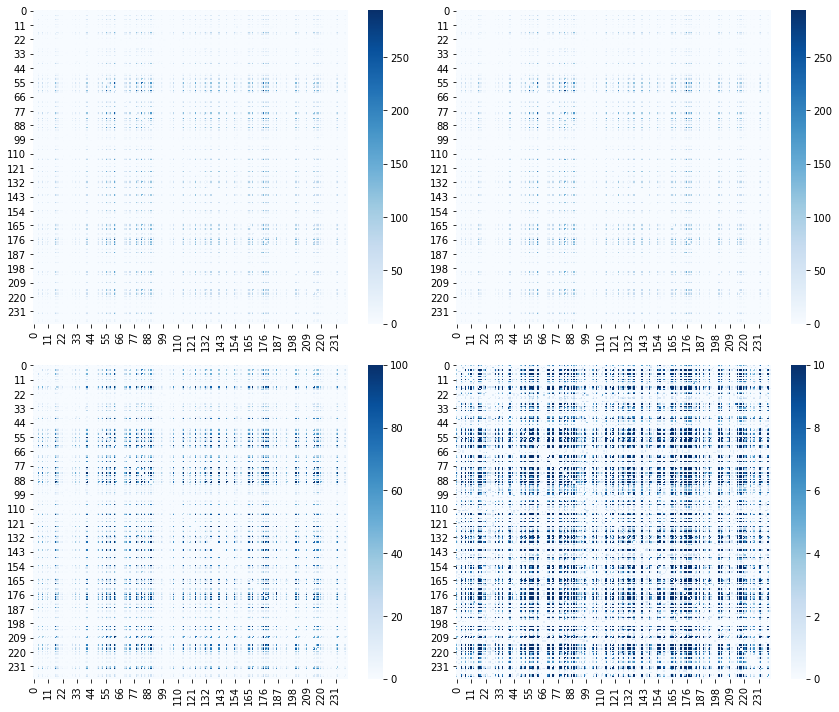

In [6]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
adj_matrix_crs = adj_matrix_crs + adj_matrix_crs.transpose() #è un network non direzionato

ns.visualize_adj(adj_matrix_crs)

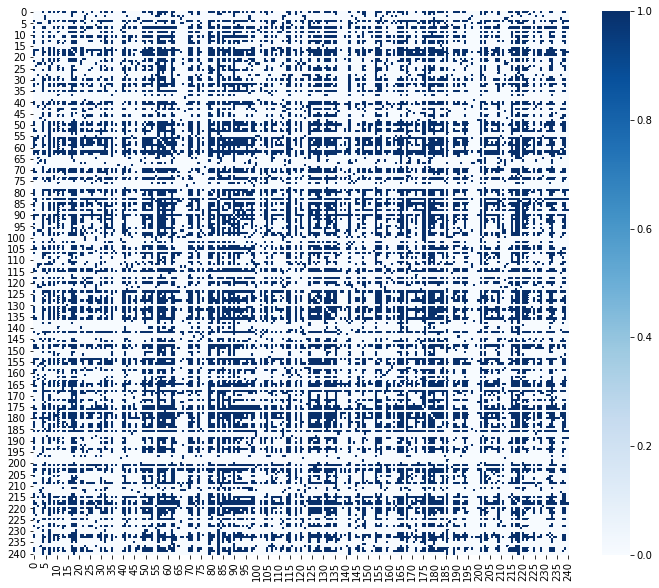

In [7]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [8]:
mobility_df.rename({'uni1': 'source','uni2': 'target', 'Participants':'weight'},axis=1, inplace=True)

In [9]:
ns.find_components(adj_matrix_crs, nodes_df)['component'].sum() #è connesso

0

### Degree distribution

In [10]:
from collections import Counter

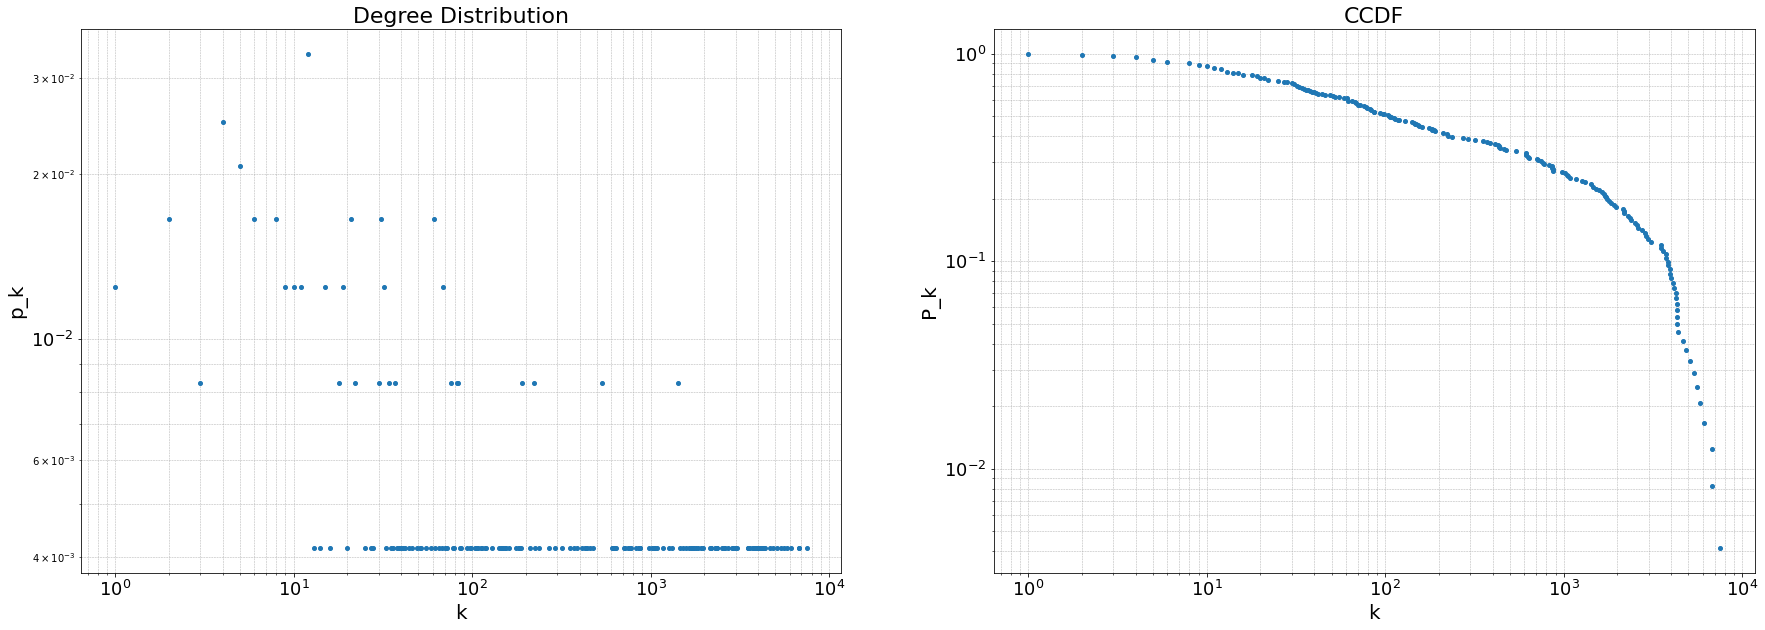

Top 10 for degree


,Nodes,degree
62,ALMA MATER STUDIORUM UNIVERSITA DI BOLOGNA,7508
176,UNIVERSITA DEGLI STUDI DI PADOVA,6788
83,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,6767
56,UNIVERSITA DEGLI STUDI DI FIRENZE,6132
79,UNIVERSITA DEGLI STUDI DI TORINO,5815
90,UNIVERSITA DEGLI STUDI DI MILANO,5602
124,UNIVERSITA DEGLI STUDI DI NAPOLI FEDERICO II,5358
180,UNIVERSITA DEGLI STUDI ROMA TRE,5106
168,UNIVERSITA DI PISA,4846
115,UNIVERSITA DEGLI STUDI DI GENOVA,4675


In [11]:
scores = nodes_df.copy()
N = len(nodes_df.index)
d = adj_matrix_crs.dot(np.ones(N))
d = d.astype(int)
scores['degree'] = d
d = d[d > 0]

sorted_d = sorted(d)
occurrence = Counter(sorted_d)
x = list(occurrence.keys())
y = list(occurrence.values())
y = y/np.sum(y)
Pk = 1 - np.cumsum(y) # complementary cumulative
Pk[-1] = 1 
Pk = sorted(Pk, reverse = True)

fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ns.plot_probability_loglog(ax[0], x, y, "Degree Distribution")
ns.plot_probability_loglog(ax[1], x, Pk, "CCDF", True)
plt.show()

ns.display_top_n(scores, 10, 'degree')

### HITS (NetworkX)

In [12]:
import networkx as nx

In [13]:
hh, aa = nx.algorithms.link_analysis.hits_alg.hits(nx.Graph(adj_matrix_crs), tol = 1e-4/len(nx.Graph(adj_matrix_crs)))
df_hh = pd.DataFrame.from_dict(hh, orient='index')
df_hh.rename({0:'hits'},axis = 1, inplace=True)
df = pd.concat([nodes_df, df_hh], axis=1)

scores = pd.merge(scores, df, on='Nodes')

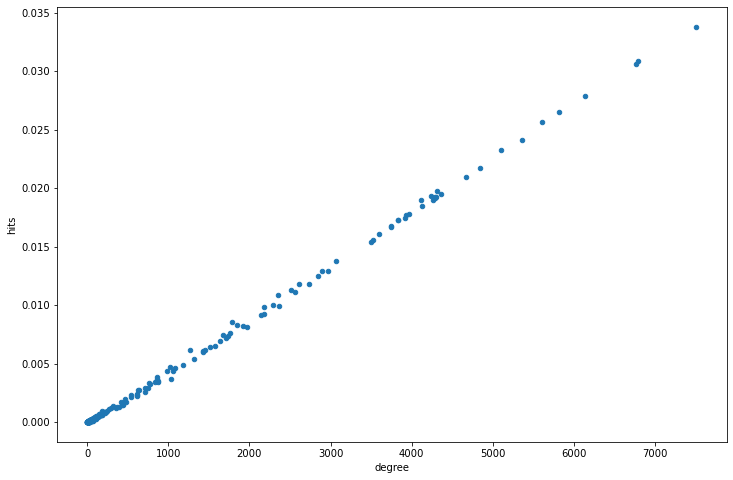

Top 10 for hits


,Nodes,hits
62,ALMA MATER STUDIORUM UNIVERSITA DI BOLOGNA,0.033804
176,UNIVERSITA DEGLI STUDI DI PADOVA,0.030872
83,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.030574
56,UNIVERSITA DEGLI STUDI DI FIRENZE,0.027911
79,UNIVERSITA DEGLI STUDI DI TORINO,0.026534
90,UNIVERSITA DEGLI STUDI DI MILANO,0.025674
124,UNIVERSITA DEGLI STUDI DI NAPOLI FEDERICO II,0.024147
180,UNIVERSITA DEGLI STUDI ROMA TRE,0.023236
168,UNIVERSITA DI PISA,0.021761
115,UNIVERSITA DEGLI STUDI DI GENOVA,0.020937


In [14]:
fig, ax1 = plt.subplots(figsize=(12,8))
scores.plot('degree', 'hits', kind='scatter', ax=ax1)
plt.show()

ns.display_top_n(scores, 10, 'hits')

### PageRank (NetworkX)

In [15]:
hh = nx.algorithms.link_analysis.pagerank_alg.pagerank(nx.Graph(adj_matrix_crs), tol = (1e-4)/len(nx.Graph(adj_matrix_crs)))
df_hh = pd.DataFrame.from_dict(hh, orient='index')
df_hh.rename({0:'PageRank'},axis = 1, inplace=True)
df = pd.concat([nodes_df, df_hh], axis=1)

scores = pd.merge(scores, df, on='Nodes')

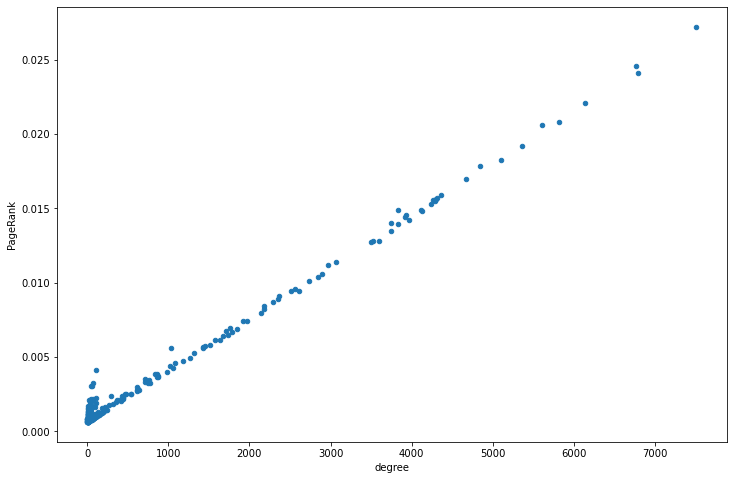

Top 10 for PageRank


,Nodes,PageRank
62,ALMA MATER STUDIORUM UNIVERSITA DI BOLOGNA,0.027237
83,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.024580
176,UNIVERSITA DEGLI STUDI DI PADOVA,0.024088
56,UNIVERSITA DEGLI STUDI DI FIRENZE,0.022085
79,UNIVERSITA DEGLI STUDI DI TORINO,0.020826
90,UNIVERSITA DEGLI STUDI DI MILANO,0.020613
124,UNIVERSITA DEGLI STUDI DI NAPOLI FEDERICO II,0.019206
180,UNIVERSITA DEGLI STUDI ROMA TRE,0.018277
168,UNIVERSITA DI PISA,0.017881
115,UNIVERSITA DEGLI STUDI DI GENOVA,0.016951


In [16]:
fig, ax1 = plt.subplots(figsize=(12,8))
scores.plot('degree', 'PageRank', kind='scatter', ax=ax1)
plt.show()

ns.display_top_n(scores, 10, 'PageRank')

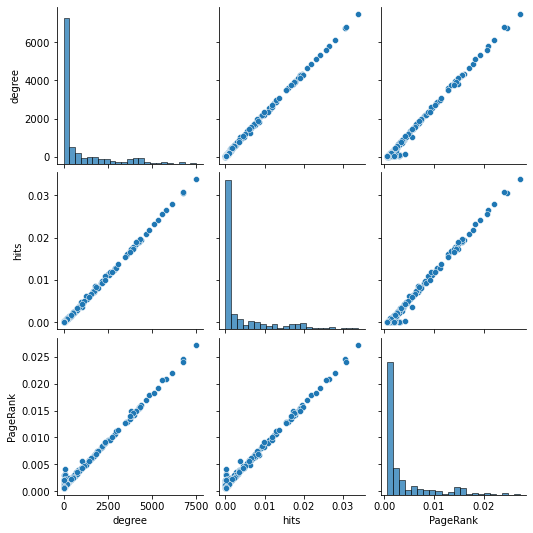

In [17]:
sns.pairplot(scores[['degree', 'hits', 'PageRank']])
plt.show()